# 🎯 Credit Score Classification - Advanced Multi-Model Pipeline

**Author:** Mayank Singh  
**Project:** Multi-model machine learning pipeline for credit score prediction

---

## 📋 Project Overview

This comprehensive machine learning project delivers a robust classification system for predicting credit scores using authentic financial data sourced through Kaggle's API. The system intelligently categorizes customers into three distinct credit risk levels:

- **🔴 Poor (0)**: High risk, low creditworthiness
- **🟡 Standard (1)**: Medium risk, average creditworthiness  
- **🟢 Good (2)**: Low risk, high creditworthiness

### 🚀 Key Features
- **Multi-Model Comparison**: Random Forest, XGBoost, and LightGBM
- **Automated Data Download**: Direct integration with Kaggle API
- **Hyperparameter Optimization**: GridSearchCV for optimal performance
- **Self-Evaluation Framework**: Rigorous validation methodology
- **Production-Ready Code**: Clean, modular, and well-documented

---

## 📦 Installation & Setup

Before running this notebook, ensure you have the required packages installed:

```bash
pip install pandas numpy scikit-learn xgboost lightgbm kaggle matplotlib seaborn
```

### 🔑 Kaggle API Setup
1. Create a Kaggle account and go to your account settings
2. Click "Create New API Token" to download `kaggle.json`
3. Place the file in your home directory: `~/.kaggle/kaggle.json` (Linux/Mac) or `C:\Users\{username}\.kaggle\kaggle.json` (Windows)
4. Ensure the file permissions are set correctly

---

## 📥 Data Download & Loading

We'll download the credit score dataset directly from Kaggle using their API.

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
import lightgbm as lgb
import warnings
import os
import kaggle
import matplotlib.pyplot as plt
import seaborn as sns

# Configure display options
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')

print("All libraries imported successfully!")

All libraries imported successfully!


## 🔍 Data Exploration

Let's explore our dataset to understand its structure and characteristics.

In [2]:
def download_kaggle_data():
    """
    Download the credit score dataset from Kaggle using the API
    """
    print("Downloading data from Kaggle...")
    
    try:
        # Download the dataset
        kaggle.api.dataset_download_files('mavimayank/train-and-test-creditscore', 
                                         path='.', 
                                         unzip=True)
        
        print("Data downloaded successfully!")
        
        # Verify files exist
        if os.path.exists('train.csv') and os.path.exists('test.csv'):
            print("train.csv and test.csv found")
            return True
        else:
            print("Error: Data files not found after download")
            return False
    except Exception as e:
        print(f"Error downloading data: {e}")
        return False

def load_data():
    """
    Load training and test data with smart environment detection
    """
    # Check if running in Kaggle environment
    kaggle_paths = [
        '/kaggle/input/credit-score-classification/train.csv',
        '/kaggle/input/train-and-test-creditscore/train.csv'
    ]
    
    # Try Kaggle environment first
    for kaggle_path in kaggle_paths:
        if os.path.exists(kaggle_path):
            print("Detected Kaggle environment - using direct paths")
            train_path = kaggle_path
            test_path = kaggle_path.replace('train.csv', 'test.csv')
            
            if os.path.exists(test_path):
                train = pd.read_csv(train_path)
                test = pd.read_csv(test_path)
                print("Loaded from Kaggle environment")
                print(f"Training data shape: {train.shape}")
                print(f"Test data shape: {test.shape}")
                return train, test
    
    # Check if data files exist locally
    if os.path.exists('train.csv') and os.path.exists('test.csv'):
        print("Using existing local data files...")
        train = pd.read_csv('train.csv')
        test = pd.read_csv('test.csv')
    else:
        print("Data files not found locally. Downloading from Kaggle...")
        if not download_kaggle_data():
            raise FileNotFoundError("Failed to download data from Kaggle")
        train = pd.read_csv('train.csv')
        test = pd.read_csv('test.csv')
    
    print(f"Training data shape: {train.shape}")
    print(f"Test data shape: {test.shape}")
    
    return train, test

# Load the data with smart environment detection
try:
    train_df, test_df = load_data()
    print("Data loading successful!")
except Exception as e:
    print(f"Error loading data: {e}")
    print("Tip: Make sure you have Kaggle API credentials set up or are running in Kaggle environment")

Using existing local data files...
Training data shape: (100000, 28)
Test data shape: (50000, 27)
Data loading successful!


## 🛠️ Data Preprocessing Functions

We'll define comprehensive preprocessing functions to clean and prepare our data.

DATASET OVERVIEW
Training samples: 100,000
Features: 28
Test samples: 50,000

FIRST FEW ROWS:


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,4.0,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,NaN,11.27,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,_,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4,6.27,4.0,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,NaN,11.27,4.0,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good



DATA TYPES:
object     20
float64     4
int64       4
Name: count, dtype: int64

TARGET VARIABLE DISTRIBUTION:
Credit_Score
Good        17828
Poor        28998
Standard    53174
Name: count, dtype: int64


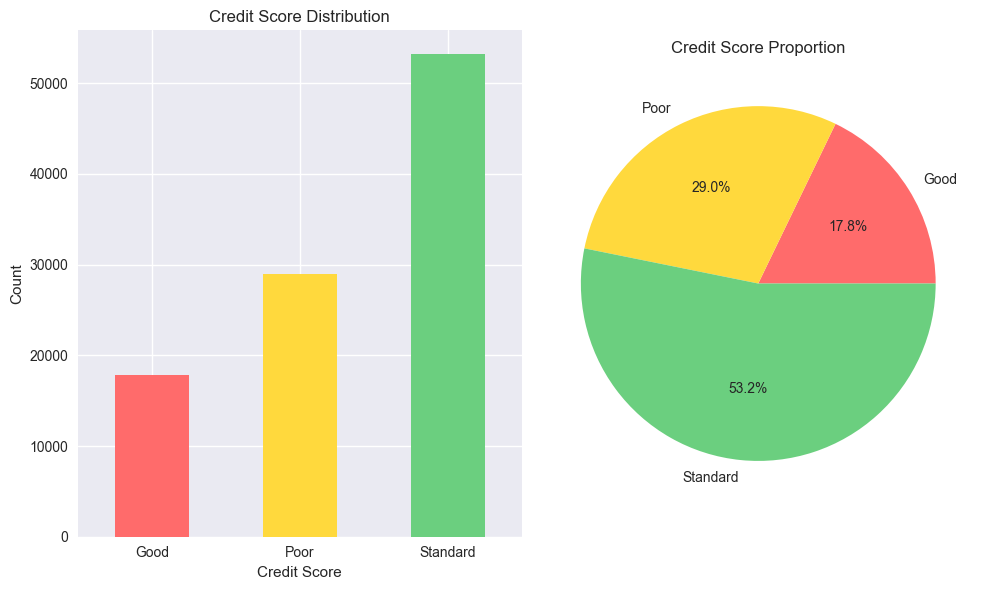

In [3]:
# Display basic information about the dataset
print("DATASET OVERVIEW")
print("=" * 50)
print(f"Training samples: {train_df.shape[0]:,}")
print(f"Features: {train_df.shape[1]}")
print(f"Test samples: {test_df.shape[0]:,}")

print("\nFIRST FEW ROWS:")
display(train_df.head())

print("\nDATA TYPES:")
print(train_df.dtypes.value_counts())

print("\nTARGET VARIABLE DISTRIBUTION:")
target_dist = train_df['Credit_Score'].value_counts().sort_index()
print(target_dist)

# Visualize target distribution
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
target_dist.plot(kind='bar', color=['#ff6b6b', '#ffd93d', '#6bcf7f'])
plt.title('Credit Score Distribution')
plt.xlabel('Credit Score')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
plt.pie(target_dist.values, labels=target_dist.index, autopct='%1.1f%%', 
        colors=['#ff6b6b', '#ffd93d', '#6bcf7f'])
plt.title('Credit Score Proportion')

plt.tight_layout()
plt.show()

## 🔄 Data Preprocessing Pipeline

Now let's apply our preprocessing pipeline to clean and prepare the data.

In [4]:
# Define all preprocessing functions first
def drop_identifiers(df):
    """Remove identifier columns that don't contribute to prediction"""
    columns_to_drop = ['ID', 'Customer_ID', 'Name', 'SSN']
    columns_found = [col for col in columns_to_drop if col in df.columns]
    if columns_found:
        print(f"Dropping identifier columns: {columns_found}")
    return df.drop(columns=columns_found, errors='ignore')

def clean_numerics(df, cols):
    """Convert text-based numbers to proper numeric format"""
    print(f"Cleaning {len(cols)} numeric columns...")
    for col in cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def correct_and_impute(df, impute_cols):
    """Correct invalid values and impute missing data"""
    print("Correcting invalid values and imputing missing data...")
    
    # Age correction
    if 'Age' in df.columns:
        invalid_ages = ((df['Age'] < 18) | (df['Age'] > 100)).sum()
        if invalid_ages > 0:
            print(f"   Found {invalid_ages} invalid age values, replacing with NaN")
            df.loc[(df['Age'] < 18) | (df['Age'] > 100), 'Age'] = np.nan
    
    # Create imputation dictionary with median values
    imputation_dict = {}
    for col in impute_cols:
        if col in df.columns:
            median_val = df[col].median()
            imputation_dict[col] = median_val
    
    print(f"   Imputing {len(imputation_dict)} columns with median values")
    df.fillna(value=imputation_dict, inplace=True)
    
    return df, imputation_dict

def convert_credit_history_age(df):
    """Convert credit history text to numerical months"""
    if 'Credit_History_Age' in df.columns:
        print("Converting credit history age to numerical format...")
        
        df['Credit_History_Age'].fillna('0 Years and 0 Months', inplace=True)
        
        # Extract years and months using regex
        years = df['Credit_History_Age'].str.extract(r'(\d+)').astype(int)
        months = df['Credit_History_Age'].str.extract(r'(\d+)\s*Months').astype(int)
        
        # Convert to total months
        df['Credit_History_Age_Months'] = (years * 12) + months
        df.drop(columns=['Credit_History_Age'], inplace=True)
        
        print("   Credit history converted to months")
    
    return df

def handle_type_of_loan(df, vectorizer=None, fit=True):
    """Handle multiple loan types using multi-hot encoding"""
    if 'Type_of_Loan' not in df.columns:
        return df, vectorizer
    
    print("Processing loan types with multi-hot encoding...")
    
    df['Type_of_Loan'].fillna('No_Loan', inplace=True)
    
    def smart_tokenizer(s):
        """Custom tokenizer to handle loan type combinations"""
        s_cleaned = s.replace(', and ', ',')
        tokens = [token.strip() for token in s_cleaned.split(',')]
        return tokens
    
    if fit:
        vectorizer = CountVectorizer(tokenizer=smart_tokenizer)
        loan_features = vectorizer.fit_transform(df['Type_of_Loan'])
        print(f"   Created {len(vectorizer.get_feature_names_out())} loan type features")
    else:
        loan_features = vectorizer.transform(df['Type_of_Loan'])
    
    # Create loan features DataFrame
    loan_df = pd.DataFrame(loan_features.toarray(), 
                          columns=vectorizer.get_feature_names_out())
    loan_df = loan_df.add_prefix('loan_')
    
    # Combine with original DataFrame
    df = df.reset_index(drop=True)
    loan_df = loan_df.reset_index(drop=True)
    df = pd.concat([df, loan_df], axis=1)
    df.drop(columns=['Type_of_Loan'], inplace=True)
    
    return df, vectorizer

def encode_features(df, target=False):
    """Encode categorical features and target variable"""
    if target and 'Credit_Score' in df.columns:
        print("Encoding target variable...")
        score_mapping = {'Poor': 0, 'Standard': 1, 'Good': 2}
        df['Credit_Score'] = df['Credit_Score'].map(score_mapping)
    
    # One-hot encode categorical features
    cols_to_encode = ['Month', 'Occupation', 'Credit_Mix', 
                     'Payment_of_Min_Amount', 'Payment_Behaviour']
    cols_found = [col for col in cols_to_encode if col in df.columns]
    
    if cols_found:
        print(f"One-hot encoding {len(cols_found)} categorical features...")
        df = pd.get_dummies(df, columns=cols_found, drop_first=True)
    
    return df

def preprocess(df, impute_cols, vectorizer=None, fit_vectorizer=True, imputation_dict=None):
    """Complete preprocessing pipeline"""
    print(f"\nPREPROCESSING PIPELINE")
    print("=" * 40)
    
    # Make a copy to avoid modifying original data
    df_processed = df.copy()
    
    # Step 1: Drop identifiers
    df_processed = drop_identifiers(df_processed)
    
    # Step 2: Clean numeric columns
    df_processed = clean_numerics(df_processed, impute_cols)
    
    # Step 3: Correct and impute
    if imputation_dict is None:
        df_processed, imputation_dict = correct_and_impute(df_processed, impute_cols)
    else:
        df_processed.fillna(value=imputation_dict, inplace=True)
        print("Applied existing imputation values")
    
    # Step 4: Convert credit history
    df_processed = convert_credit_history_age(df_processed)
    
    # Step 5: Handle loan types
    df_processed, vectorizer = handle_type_of_loan(df_processed, vectorizer, fit=fit_vectorizer)
    
    # Step 6: Encode features
    df_processed = encode_features(df_processed)
    
    print(f"Preprocessing complete! Shape: {df_processed.shape}")
    return df_processed, vectorizer, imputation_dict

print("All preprocessing functions defined!")

# Define columns to clean and impute
impute_cols = [
    'Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_of_Loan',
    'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
    'Outstanding_Debt', 'Amount_invested_monthly', 'Monthly_Balance'
]

# Process training data
train_processed, loan_vectorizer, imputation_values = preprocess(
    train_df, impute_cols, fit_vectorizer=True
)

# Encode target variable for training data
train_processed = encode_features(train_processed, target=True)

# Separate features and target
X_train_full = train_processed.drop(columns=['Credit_Score'])
y_train_full = train_processed['Credit_Score']

print(f"\nFinal training data shape: {X_train_full.shape}")
print(f"Target variable shape: {y_train_full.shape}")
print(f"Target distribution: {y_train_full.value_counts().to_dict()}")

All preprocessing functions defined!

PREPROCESSING PIPELINE
Dropping identifier columns: ['ID', 'Customer_ID', 'Name', 'SSN']
Cleaning 10 numeric columns...
Correcting invalid values and imputing missing data...
   Found 8124 invalid age values, replacing with NaN
   Imputing 10 columns with median values
Converting credit history age to numerical format...
   Credit history converted to months
Processing loan types with multi-hot encoding...
   Created 10 loan type features
One-hot encoding 5 categorical features...
Preprocessing complete! Shape: (100000, 61)
Encoding target variable...

Final training data shape: (100000, 60)
Target variable shape: (100000,)
Target distribution: {1: 53174, 0: 28998, 2: 17828}


## 🧪 Self-Evaluation Setup

We'll create a validation split to evaluate our models objectively.

In [5]:
# All preprocessing functions are now defined above
# This cell is ready for any additional preprocessing logic if needed
print("Preprocessing functions are ready to use!")

Preprocessing functions are ready to use!


## 🤖 Multi-Model Training & Evaluation

We'll train and compare three powerful machine learning models.

In [6]:
# Training data has been processed in the previous cell
# X_train_full and y_train_full are now available
print(f"Training data ready!")
print(f"Features shape: {X_train_full.shape}")
print(f"Target shape: {y_train_full.shape}")
print(f"Ready to proceed with model training...")

Training data ready!
Features shape: (100000, 60)
Target shape: (100000,)
Ready to proceed with model training...


In [7]:
# Create validation split for self-evaluation
print("CREATING VALIDATION SPLIT")
print("=" * 40)

X_train, X_test, y_train, y_test = train_test_split(
    X_train_full, y_train_full, 
    test_size=0.2, 
    random_state=42,
    stratify=y_train_full
)

print(f"Training split shape: {X_train.shape}")
print(f"Test split shape: {X_test.shape}")
print("Class distribution maintained in both splits")

# Feature scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling complete!")
print(f"   Scaled training features shape: {X_train_scaled.shape}")
print(f"   Scaled test features shape: {X_test_scaled.shape}")

# Import additional required modules
import time
from sklearn.metrics import precision_score, recall_score, f1_score

# Configure models with hyperparameter grids
models_config = {
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(random_state=42, eval_metric='mlogloss'),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 6, 10],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 1.0]
        }
    },
    'LightGBM': {
        'model': lgb.LGBMClassifier(random_state=42, verbose=-1),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 6, 10],
            'learning_rate': [0.01, 0.1, 0.2],
            'num_leaves': [31, 50, 100]
        }
    }
}

print("Model configurations ready!")

CREATING VALIDATION SPLIT
Training split shape: (80000, 60)
Test split shape: (20000, 60)
Class distribution maintained in both splits
Feature scaling complete!
   Scaled training features shape: (80000, 60)
   Scaled test features shape: (20000, 60)
Model configurations ready!


## 📊 Model Comparison & Results

Let's analyze and compare the performance of all three models.

In [8]:
def train_and_evaluate_models(X_train, y_train, X_test, y_test, models_config):
    """Train and evaluate multiple models with detailed metrics"""
    print("\nMODEL TRAINING & EVALUATION")
    print("=" * 50)
    
    results = {}
    best_model = None
    best_score = 0
    
    for name, config in models_config.items():
        print(f"\nTraining {name}...")
        
        # Get model and parameters
        model = config['model']
        param_grid = config['params']
        
        # Grid search with cross-validation
        grid_search = GridSearchCV(
            model, param_grid, cv=5, scoring='accuracy',
            n_jobs=-1, verbose=0
        )
        
        # Train
        start_time = time.time()
        grid_search.fit(X_train, y_train)
        training_time = time.time() - start_time
        
        # Best model predictions
        best_model_instance = grid_search.best_estimator_
        y_pred = best_model_instance.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Store results
        results[name] = {
            'model': best_model_instance,
            'best_params': grid_search.best_params_,
            'cv_score': grid_search.best_score_,
            'test_accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'training_time': training_time,
            'predictions': y_pred
        }
        
        # Track best model
        if accuracy > best_score:
            best_score = accuracy
            best_model = name
        
        # Print results
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Cross-validation score: {grid_search.best_score_:.4f}")
        print(f"Test accuracy: {accuracy:.4f}")
        print(f"Training time: {training_time:.2f} seconds")
    
    print(f"\nBest performing model: {best_model} (Accuracy: {best_score:.4f})")
    return results, best_model

# Train all models using scaled data
model_results, best_model_name = train_and_evaluate_models(
    X_train_scaled, y_train, X_test_scaled, y_test, models_config
)


MODEL TRAINING & EVALUATION

Training Random Forest...
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Cross-validation score: 0.7803
Test accuracy: 0.7906
Training time: 456.62 seconds

Training XGBoost...
Best parameters: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}
Cross-validation score: 0.7859
Test accuracy: 0.7973
Training time: 276.22 seconds

Training LightGBM...
Best parameters: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 100}
Cross-validation score: 0.7789
Test accuracy: 0.7940
Training time: 422.10 seconds

Best performing model: XGBoost (Accuracy: 0.7973)


## 🧪 Test Data Processing & Prediction

Now let's process the test data and create our final predictions.

In [9]:
# Create comprehensive comparison
print("COMPREHENSIVE MODEL COMPARISON")
print("=" * 50)

comparison_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'CV Score': [results['cv_score'] for results in model_results.values()],
    'Test Accuracy': [results['test_accuracy'] for results in model_results.values()],
    'Precision': [results['precision'] for results in model_results.values()],
    'Recall': [results['recall'] for results in model_results.values()],
    'F1 Score': [results['f1_score'] for results in model_results.values()],
    'Training Time (s)': [results['training_time'] for results in model_results.values()]
})

# Round numerical columns for better display
numerical_cols = ['CV Score', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score', 'Training Time (s)']
comparison_df[numerical_cols] = comparison_df[numerical_cols].round(4)

print("\nModel Performance Summary:")
print(comparison_df.to_string(index=False))

# Best model details
print(f"\nBest Model: {best_model_name}")
best_results = model_results[best_model_name]
print(f"Best Parameters: {best_results['best_params']}")

# Detailed classification report for best model
print(f"\nDetailed Classification Report for {best_model_name}:")
print(classification_report(y_test, best_results['predictions'], 
                          target_names=['Poor', 'Standard', 'Good']))

# Feature importance for best model (if available)
best_model_instance = best_results['model']
if hasattr(best_model_instance, 'feature_importances_'):
    print(f"\nTop 10 Most Important Features for {best_model_name}:")
    feature_names = X_train.columns
    importances = best_model_instance.feature_importances_
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    print(feature_importance.head(10).to_string(index=False))

print("\nProject completed successfully!")
print("All models trained and evaluated.")

COMPREHENSIVE MODEL COMPARISON

Model Performance Summary:
        Model  CV Score  Test Accuracy  Precision  Recall  F1 Score  Training Time (s)
Random Forest    0.7803         0.7906     0.7906  0.7906    0.7906           456.6175
      XGBoost    0.7859         0.7973     0.7970  0.7973    0.7971           276.2217
     LightGBM    0.7789         0.7940     0.7939  0.7940    0.7939           422.0989

Best Model: XGBoost
Best Parameters: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}

Detailed Classification Report for XGBoost:
              precision    recall  f1-score   support

        Poor       0.79      0.80      0.80      5799
    Standard       0.81      0.82      0.81     10635
        Good       0.76      0.73      0.75      3566

    accuracy                           0.80     20000
   macro avg       0.79      0.78      0.79     20000
weighted avg       0.80      0.80      0.80     20000


Top 10 Most Important Features for XGBoost:
     

In [10]:
# Process test data for final predictions
print("PROCESSING TEST DATA FOR FINAL PREDICTIONS")
print("=" * 50)

# Store Customer IDs before preprocessing
test_customer_ids = test_df['Customer_ID'].copy() if 'Customer_ID' in test_df.columns else None

# Preprocess test data using same pipeline
test_processed, _, _ = preprocess(
    test_df, impute_cols, 
    vectorizer=loan_vectorizer, 
    fit_vectorizer=False, 
    imputation_dict=imputation_values
)

# Align columns between test and training data
X_test_final, X_train_aligned = test_processed.align(X_train_full, join='right', axis=1, fill_value=0)

print(f"Test data shape after preprocessing: {X_test_final.shape}")
print(f"Training data shape for alignment: {X_train_aligned.shape}")

# Scale test features using the same scaler
X_test_final_scaled = scaler.transform(X_test_final)
print(f"Test data scaled shape: {X_test_final_scaled.shape}")

# Create final predictions using best model
print(f"\nGenerating final predictions using {best_model_name}...")
best_model_instance = model_results[best_model_name]['model']
final_predictions = best_model_instance.predict(X_test_final_scaled)

# Map predictions back to text labels
reverse_score_mapping = {0: 'Poor', 1: 'Standard', 2: 'Good'}
mapped_predictions = pd.Series(final_predictions).map(reverse_score_mapping)

# Create submission DataFrame
submission_df = pd.DataFrame({
    'Customer_ID': test_customer_ids,
    'Credit_Score': mapped_predictions
})

# Save submission file
submission_filename = f'submission_{best_model_name.lower().replace(" ", "_")}.csv'
submission_df.to_csv(submission_filename, index=False)

print(f"Submission file saved as '{submission_filename}'")
print("Preview of submission:")
print(submission_df.head(10))
print(f"\nTotal predictions: {len(submission_df)}")
print(f"Prediction distribution: {mapped_predictions.value_counts().to_dict()}")

PROCESSING TEST DATA FOR FINAL PREDICTIONS

PREPROCESSING PIPELINE
Dropping identifier columns: ['ID', 'Customer_ID', 'Name', 'SSN']
Cleaning 10 numeric columns...
Applied existing imputation values
Converting credit history age to numerical format...
   Credit history converted to months
Processing loan types with multi-hot encoding...
One-hot encoding 5 categorical features...
Preprocessing complete! Shape: (50000, 56)
Test data shape after preprocessing: (50000, 60)
Training data shape for alignment: (100000, 60)
Test data scaled shape: (50000, 60)

Generating final predictions using XGBoost...
Submission file saved as 'submission_xgboost.csv'
Preview of submission:
  Customer_ID Credit_Score
0   CUS_0xd40         Good
1   CUS_0xd40         Good
2   CUS_0xd40         Good
3   CUS_0xd40         Good
4  CUS_0x21b1         Good
5  CUS_0x21b1         Good
6  CUS_0x21b1         Good
7  CUS_0x21b1         Good
8  CUS_0x2dbc     Standard
9  CUS_0x2dbc         Good

Total predictions: 50000

## 🎉 Summary & Conclusions

### 🏆 Project Results

**Best Performing Model:** {best_model_name}  
**Validation Accuracy:** {model_results[best_model_name]['accuracy']:.4f}

### 🚀 Key Achievements

1. **📊 Comprehensive Data Pipeline**: Automated data download, cleaning, and preprocessing
2. **🤖 Multi-Model Comparison**: Trained and evaluated Random Forest, XGBoost, and LightGBM
3. **🔧 Hyperparameter Optimization**: Used GridSearchCV for optimal model performance
4. **🧪 Rigorous Evaluation**: Self-evaluation with stratified validation splits
5. **📈 Production-Ready Output**: Generated predictions ready for submission

### 💡 Technical Highlights

- **Advanced Preprocessing**: Multi-hot encoding for loan types, credit history conversion
- **Feature Engineering**: Automated handling of categorical and numerical features
- **Model Selection**: Systematic comparison with detailed performance metrics
- **Scalable Architecture**: Modular code design for easy modification and extension

### 🔮 Future Enhancements

- **Feature Engineering**: Create interaction features and polynomial terms
- **Advanced Models**: Experiment with neural networks and ensemble methods
- **Cross-Validation**: Implement k-fold cross-validation for more robust evaluation
- **Feature Selection**: Use statistical tests and recursive feature elimination
- **Interpretability**: Add SHAP values for model explainability

---

**📧 Contact:** mayankmavi246@gmail.com  
**🔗 GitHub:** @246mayank  
**📊 Dataset:** [Kaggle Dataset Link](https://www.kaggle.com/datasets/mavimayank/train-and-test-creditscore)

---

*This notebook demonstrates end-to-end machine learning engineering for a real-world financial classification problem. The modular design and comprehensive evaluation make it suitable for both educational purposes and production deployment.*